<a href="https://colab.research.google.com/github/edygordo/Algorithms/blob/master/Polyastro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install poliastro

Attractor, Reference frame, Period:-Earth (♁), <bound method Orbit.get_frame of 6650 x 46550 km x 63.4 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)>, 0.49971190141372096 s


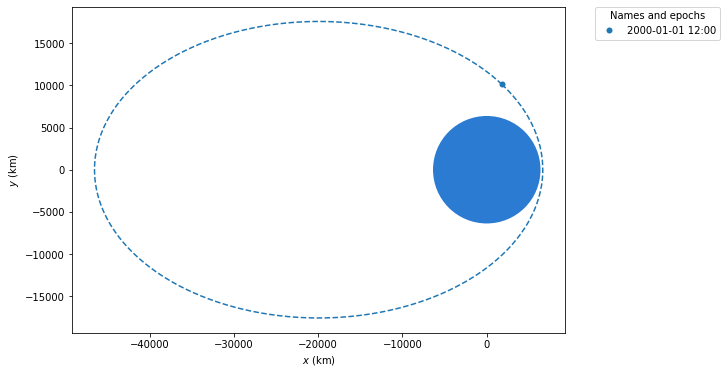

In [ ]:
from poliastro.examples import molniya
molniya.plot()
type(molniya)
print(f'Attractor, Reference frame, Period:-{molniya.attractor}, {molniya.get_frame}, {molniya.period/(24*60*60)}')

In [ ]:
from astropy import units as u
from poliastro.bodies import Mars,Earth,Sun
from poliastro.twobody import Orbit # this Orbit object stores all the relevenant information to completely define orbit(6 OEV) with time at which the orbit was defined

# Given the position r and velocity v of a satellite in the geocentric equatorial frame(ECI-J2000), how do we obtain the orbital elements?
# Data from Curtis, example 4.3
r = [-6045, -3490, 2500] * u.km
v = [-3.457, 6.618, 2.533] * u.km / u.s

orb = Orbit.from_vectors(Earth, r, v) # We define the state vector [r,v] of a satellite in geocentric equatorial frame, and Earth for (gravitational constant parameter)

type(orb)


poliastro.twobody.orbit.Orbit

<GCRS Frame (obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s)>

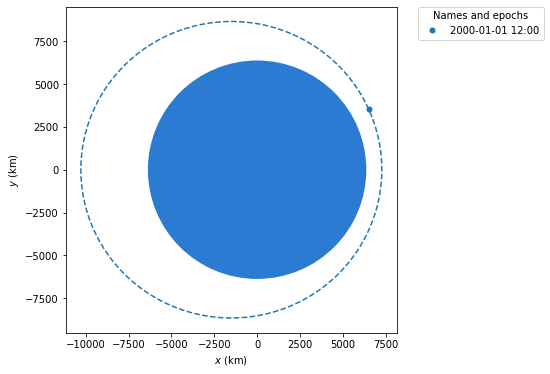

In [ ]:
orb.plot() # Plotting done in per-focal reference frame
           # The dotted line represents osculatting orbit, an ideal Keplerian Orbit at that instant of satellite
orb.epoch
orb.epoch.iso
# to get the frame in which orbit is described in use
# Geo-Centric Reference frame
orb.get_frame()

In [ ]:
# Data for Mars at J2000 from JPL HORIZONS
a = 1.523679 * u.AU
ecc = 0.093315 * u.one
inc = 1.85 * u.deg
raan = 49.562 * u.deg
argp = 286.537 * u.deg
nu = 23.33 * u.deg

# The frame of object orb is in HCRS(Helio Centric Reference System)
orb = Orbit.from_classical(Sun, a, ecc, inc, raan, argp, nu)
print(orb.get_frame())
orb.period

<HCRS Frame (obstime=J2000.000)>


<Quantity 59354327.53239401 s>

In [ ]:
# Finding a satellite parameters , nu(True Anamoly), n(Mean Motion) . Converting them to desired unit
from poliastro.examples import iss
iss.nu.to(unit=u.deg)
iss.n.to(unit=u.deg/u.min)
print(f'True Anomaly(in degree) of ISS Orbit is in:-{iss.nu.to(unit=u.deg)}')
print(f'Epoch time of ISS:-{iss.epoch}')
print(type(iss))

True Anomaly(in degree) of ISS Orbit is in:-46.5958046770576 deg
Epoch time of ISS:-2013-03-18 12:00:00.000
<class 'poliastro.twobody.orbit.Orbit'>


In [ ]:
# How to propagate a satellite in a given reference frame?
# use propagate method present in astropy
# Propagating ISS(International Space Station) for 30 minute in GCRS

iss_30m = iss.propagate(30 * u.min)
iss_30m.epoch
print(iss_30m.nu.to(unit=u.deg))
print(f'Time now:-{iss_30m.epoch.iso}')

163.14093620348706 deg
Time now:-2013-03-18 12:30:00.000


In [ ]:
# Propagation using User Defined Pertubations(Here a constant acceleration along tangent is used just for Demonstration Purpose)
from numba import njit
import numpy as np
from poliastro.core.propagation import func_twobody
from poliastro.twobody.propagation import cowell
from astropy import  units as u
r0 = [-2384.46, 5729.01, 3050.46] * u.km
v0 = [-7.36138, -2.98997, 1.64354] * u.km / u.s
initial = Orbit.from_vectors(Earth, r0, v0)
Epoch_time = initial.epoch
Initial_anomaly_degree = initial.nu.to(unit=u.deg)
Initial_eccentricity = initial.ecc

# njit is just for faster computation using numba library
# k is Orbit's Gravitational constant(mu=G*(M_attractor))
# state is numpy array[position,velocity]
# accel is providing constant acceleration(A Demo Perturbation) along the tangent. Will be useful to know how to add Other perterbations.
# norm_v is directional unit vector
# func_twobody is using a cowell model to propagte satellite in orbit, it returns d(state_vec)/dt = [velocity_3,acceleration_3]
# Note state_vec here in [km, km/s]
# func_twobody solves differential equation which is an initial value problem
# t0 = time after epoch time, u_ = state_vector[pos,vel], k = gravitational constant

@njit
def accel( state):
    """Constant acceleration aligned with the velocity. """
    v_vec = state[3:]
    norm_v = (v_vec * v_vec).sum() ** 0.5
    return 1e-5 * v_vec / norm_v

time_vec = []

def f(t0, u_, k):
    #print(f'Simulation Time is:-{t0}')
    time_vec.append(t0)
    du_kep = func_twobody(t0, u_, k)
    #print(f'Output from func_twobody(Cowell Evaluation):-{du_kep}.')
    ax, ay, az = accel( u_)
    du_ad = np.array([0, 0, 0, ax, ay, az])
    #print(f'Output from accel(Synthetic Perturbation function):-{du_ad}.')
    return du_kep + du_ad

Propagated_satellite = initial.propagate(5 * u.day,method=cowell,f=f)
Propagated_epoch_time = Propagated_satellite.epoch
Propagated_anomaly_degree = Propagated_satellite.nu.to(unit=u.deg)
Propagated_eccentricity = Propagated_satellite.ecc

In [ ]:
# Plotting of Initial state of Satellite

from poliastro.plotting import OrbitPlotter3D

print('Initial State of satellite')
print(f'Epoch time is:- {initial.epoch.iso}')
print(f'Eccentricity is:-{initial.ecc}')
print(f'Semi-Major axis is:-{initial.a}')
initial.plot(label='My Satellite',use_3d=True,interactive=True)

Initial State of satellite
Epoch time is:- 2000-01-01 12:00:00.000
Eccentricity is:-0.1713603407640222
Semi-Major axis is:-8058.987609736672 km


In [ ]:
# Plotting of Propagation of Satellite

from poliastro.plotting import OrbitPlotter3D

print('Final State of satellite(after 5 days of constant accel. along tangent)')
print(f'Epoch time is:- {Propagated_satellite.epoch.iso}')
print(f'Eccentricity is:-{Propagated_satellite.ecc}')
print(f'Semi Major axis of orbit is:-{Propagated_satellite.a}')
Propagated_satellite.plot(label='My Satellite',use_3d=True,interactive=True)

Final State of satellite(after 5 days of constant accel. along tangent)
Epoch time is:- 2000-01-06 12:00:00.000
Eccentricity is:-0.18202579646286182
Semi Major axis of orbit is:-54349.08288875658 km


In [ ]:
# Plotting the whole trajectory throughout the simulation time requires to store positions at various time steps

Propagated_satellite

44456 x 64242 km x 28.0 deg (GCRS) orbit around Earth (♁) at epoch J2000.014 (TT)

Text(0, 0.5, 'Simulation Time(sec)')

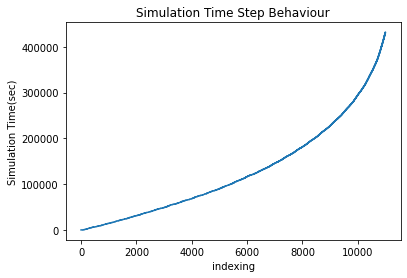

In [ ]:
import matplotlib.pyplot as plt

plt.plot(time_vec)
plt.title('Simulation Time Step Behaviour')
plt.xlabel('indexing')
plt.ylabel('Simulation Time(sec)')

In [ ]:
import poliastro

print(f'The GM for earth is:-{poliastro.constants.GM_earth}')

The GM for earth is:-398600441800000.0 m3 / s2


In [ ]:
# Creating function to extract TLE from a file and extract Keplerian OEV from it.
import numpy as np
import poliastro
import datetime
# Two Line Element Sets

# Helper functions

def ecc_anomaly(arr,method,tol=1e-8):
  if method == 'newton':
    # Netwon method for iteratively finding E
    Me, e = arr
    if Me<np.pi/2.0:
      E0 = Me+e/2.0
    else:
      E0 = Me-e
    
    for n in ranges(200):
      ratio = (E0-e*np.sin(E0)-Me)/(1-e*np.cos(E0));
      if abs(ratio)<tol:
        if n==0: return E0
        else: returnE1

    # if algo didn't converge
    return False;
  elif method=='tae':
    ta,e = arr
    return 2*np.arctan(np.sqrt((1-e)/(1+e))*np.tan(ta/2.0))
  else:
    print( 'Invalid Method for eccentric anomaly')


def calc_epoch(epoch):
  # epoch year
  year = int('20'+epoch[:2])
  epoch = epoch[2:].split('.')

  # day of year
  day_of_year = int(epoch[0])-1

  # decimal hour of day
  hour = float('0.'+epoch[1])*24.0

  # get year-month-day
  date = datetime.date(year,1,1) + datetime.timedelta(day_of_year)

  # extract month and day
  month = float(date.month)
  day = float(date.day)

  return year,month,day,hour

def tle2coes(tle_filename,poliastro.constants.GM_earth):
  # Read TLE file
  with open(tle_filename,'r') as f:
    lines = f.readlines()

    # Separe TLE data into 3 lines
    line0 = lines[0].strip() # name of satellite
    line1 = lines[1].strip().split()
    line2 = lines[2].strip().split()

    #epoch (year and day)
    epoch = line1[3]
    year, month, day, hour = calc_epoch(epoch)

    # collect coes

    #inclination
    i = float(line2[2]) # in degree

    # raan(right angle of ascension node)
    raan = float(line2[3]) # in degree

    # eccentricity
    e_string = line2[4]
    e = float('0.'+e_string)

    # argument of perigee
    arg_per = float(line2[5]) # in degree, I didn't use omega as I get confused afterwards

    # mean anomaly
    Me = float(line2[6]) # in degree
    
    # mean motion
    mean_motion = float(line2[7]) # revs/day

    # period
    T = mean_motion*24*3600 # Time period in seconds
    f = 1/T

    # semi major axis
    a = (f**2*mu/4.0/np.pi**2)**(1/3.0) 

    # calculate eccentric anomaly
    E = ecc_anomal([Me,e],'newtown') # Depends on this function

    # calculate true anomaly
    true_an = true_anamoly([E,e])

    # magnitude of radius vector
    r_mag = a*(1-e*np.cos(E))

    return a,e,i,true_an,arg_per, raan, [year, month, day, hour]

SyntaxError: ignored